In [25]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from yome import Session
from yome.models import *
from yome.util import to_df, report, scale_color
import re
from sqlalchemy import exists, distinct
from sqlalchemy.orm import aliased
from yome.constants import (
    colors_by_number as colors,
    hatches_by_number as hatches,
)

%mpl_setup

sns.set_style('ticks')

session = Session()

Populating the interactive namespace from numpy and matplotlib


# Load IterativeWCGNA modules

In [26]:
df = pd.read_table('../data/wgcna-membership-minmod10-2018-12-02.tsv', sep='\t').rename(columns={'Gene': 'locus_tag'})

In [27]:
df.head()

,locus_tag,Module,kME
0,b0001,P2_I5_M8,0.92
1,b0002,UNCLASSIFIED,NaN
2,b0003,UNCLASSIFIED,NaN
3,b0004,UNCLASSIFIED,NaN
4,b0005,UNCLASSIFIED,NaN


# Load expression data

In [28]:
tpm_log = pd.read_table('../data/precise/tpm-log.tsv', sep='\t', index_col='locus_tag')

# get gene names & descriptions

In [29]:
# List EcoCyc feature types
(session.query(distinct(KnowledgebaseFeature.feature_type))
 .join(KnowledgebaseGene)
 .join(Knowledgebase)
 .filter(Knowledgebase.name == 'EcoCyc')).all()

[('summary_html'),
 ('product_type'),
 ('is_pseudogene'),
 ('is_phantom_gene'),
 ('is_insertion_element'),
 ('description'),
 ('evidence_html'),
 ('component_html'),
 ('ec_number'),
 ('reaction_equation')]

In [30]:
# EcoCyc descriptions
ec = to_df((
    session.query(Gene.locus_id, 
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
).all(), ['locus_tag', 'primary_name', 'description'])

In [31]:
ec.head()

,locus_tag,primary_name,description
0,b4584,rpnD,truncated recombination-promoting nuclease-lik...
1,b3328,gspG,Type II secretion system protein GspG
2,b1001,yccE,uncharacterized protein YccE
3,b2467,nudK,GDP-mannose hydrolase
4,b3549,tag,"3-methyl-adenine DNA glycosylase I, constitutive"


# Get y-ome annotations

In [32]:
yome_genes = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.annotation_quality)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'y-ome')
).rename(columns={'locus_id': 'locus_tag'})

# Join to clusters

In [33]:
clusters = df.merge(ec).merge(yome_genes)

In [34]:
g_clusters = clusters.groupby('Module')

In [35]:
for name, group in g_clusters:
    print(name, len(group))
    display(group.sort_values('kME', ascending=False).head())
    break

P1_I7_M1 160


,locus_tag,Module,kME,primary_name,description,annotation_quality
2155,b2302,P1_I7_M1,0.97,yfcG,disulfide reductase,high
1991,b2131,P1_I7_M1,0.97,osmF,glycine betaine ABC transporter periplasmic bi...,high
2198,b2347,P1_I7_M1,0.97,yfdC,inner membrane protein YfdC,low
743,b0808,P1_I7_M1,0.97,ybiO,moderate conductance mechanosensitive channel,high
2793,b3003,P1_I7_M1,0.96,yghA,NADP,high


# Get number of genes by annotation quality in each group

In [36]:
def high(x): 
    return x.value_counts().get('high')
def low(x):
    return x.value_counts().get('low')
def excluded(x):
    return x.value_counts().get('excluded')
quality_counts = pd.DataFrame(g_clusters.annotation_quality.agg([high, low, excluded])).fillna(0)
quality_counts['size'] = quality_counts.sum(axis=1)
quality_counts.sort_values('size', ascending=False, inplace=True)
quality_counts = quality_counts.astype(int)

# rename clusters
quality_counts['new_cluster_names'] = ['unclassified'] + [f'M{x + 1}' for x in range(len(quality_counts) - 1)]
module_renaming_rev = dict(quality_counts['new_cluster_names'])
module_renaming = {v: k for k, v in dict(quality_counts['new_cluster_names']).items()}
quality_counts = quality_counts.reset_index().set_index('new_cluster_names').drop('Module', axis=1)
quality_counts.index.name = 'Module'
quality_counts.head() 

,high,low,excluded,size
Module,,,,
unclassified,1797,1151,92,3040
M1,99,61,0,160
M2,45,31,0,76
M3,44,24,2,70
M4,42,12,0,54


In [37]:
print('Total genes in a cluster by type:')
by_type = quality_counts.drop('size', axis=1)
by_type.index.name = 'cluster'
by_type.reset_index(inplace=True)
by_type['in_cluster'] = by_type.cluster != 'unclassified'
by_type.groupby('in_cluster').agg(np.sum)

Total genes in a cluster by type:


,high,low,excluded
in_cluster,,,
False,1797,1151,92
True,840,347,4


In [38]:
levels = {
    None: -1,
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
}
names = {'high': 'Well-annotated', 'low': 'y-ome', 'excluded': 'Pseudogene or phantom gene'}

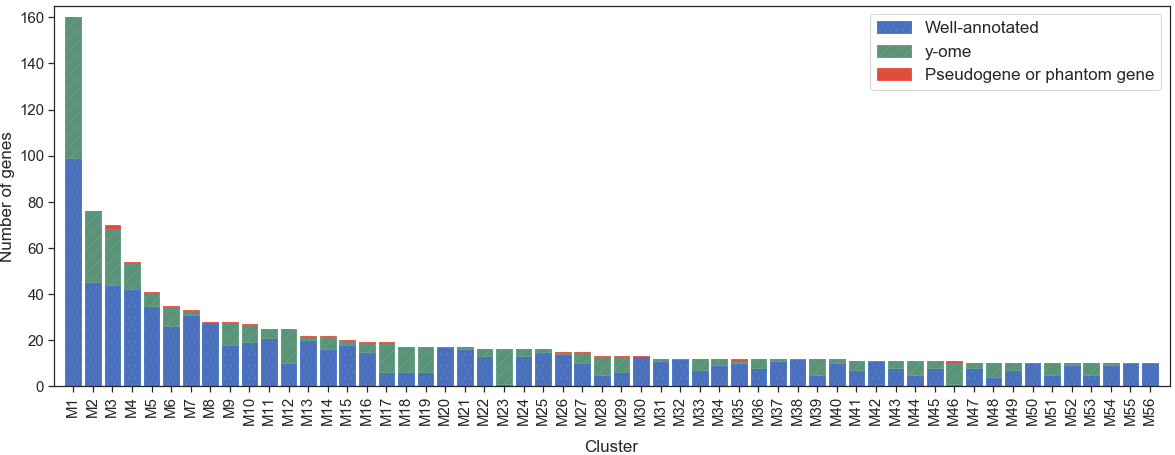

In [39]:
fig, ax = plt.subplots(figsize=(20, 7))
to_plot = quality_counts.drop('unclassified').drop('size', axis=1)
last = [0] * len(to_plot)
for label, column in to_plot.T.iterrows():
    c = colors[levels[label]]
    ax.bar(range(len(column)), column, bottom=last, color=c, hatch=hatches[levels[label]], edgecolor=scale_color(c, 1.1), label=names[label])
    last = column + last
ax.set_xticklabels(to_plot.index, rotation='vertical')
ax.set_xticks(range(len(to_plot)))
ax.set_ylabel('Number of genes')
ax.set_xlabel('Cluster', labelpad=15)
ax.set_xlim([-1, len(to_plot)])
ax.set_ylim(top=165)
ax.legend()
fig.set_facecolor('white')
# fig.savefig('/Users/zaking/lab/y-ome/figs/clusters.pdf')
# fig.savefig('/Users/zaking/lab/y-ome/figs/clusters.png')

# Export

In [49]:
clusters_filtered = clusters.copy()
clusters_filtered.loc[:, 'Module'] = clusters_filtered.loc[:, 'Module'].apply(lambda x: module_renaming_rev[x])
clusters_filtered.annotation_quality = clusters_filtered.annotation_quality.apply(lambda x: 'y-ome' if x == 'low' else 'well-annotated' if x == 'high' else x)
(clusters_filtered[clusters_filtered.Module != 'unclassified']
 .sort_values('Module')
 .to_csv('../data/clusters.tsv', sep='\t', index=False))

## highest y-ome percentage

In [41]:
quality_counts_frac = quality_counts.loc[:,:]
quality_counts_frac['yome_fraction'] = quality_counts_frac.low / quality_counts_frac['size']

In [42]:
quality_counts_frac.sort_values('yome_fraction', ascending=True).head(20)

,high,low,excluded,size,yome_fraction
cluster,,,,,
M56,10,0,0,10,0.000000
M38,12,0,0,12,0.000000
M55,10,0,0,10,0.000000
M42,11,0,0,11,0.000000
M50,10,0,0,10,0.000000
M20,17,0,0,17,0.000000
M8,28,0,0,28,0.000000
M30,13,0,0,13,0.000000
M32,12,0,0,12,0.000000


In [43]:
quality_counts_frac.sort_values('yome_fraction', ascending=False).head()

,high,low,excluded,size,yome_fraction
cluster,,,,,
M23,1,15,0,16,0.937500
M46,1,9,1,11,0.818182
M17,6,13,0,19,0.684211
M19,6,11,0,17,0.647059
M18,6,11,0,17,0.647059


In [62]:
(g_clusters.get_group(module_renaming['M21'])
 .applymap(lambda x: 'y-ome' if x == 'low' else 'well-annotated' if x == 'high' else x)
 .loc[:, ['locus_tag', 'primary_name', 'description', 'annotation_quality']]
 .rename(columns={'locus_tag': 'Locus tag', 'primary_name': 'Primary name', 'description': 'Description', 'annotation_quality': 'Category'})
 .to_csv('../data/cluster-M21.tsv', sep='\t', index=False))

In [44]:
g_clusters.get_group(module_renaming['M23'])

,locus_tag,Module,kME,primary_name,description,annotation_quality
305,b0329,P2_I5_M12,0.91,yahO,DUF1471 domain-containing protein YahO,low
404,b0435,P2_I5_M12,0.90,bolA,DNA-binding transcriptional dual regulator BolA,high
935,b1003,P2_I5_M12,0.88,yccJ,PF13993 family protein YccJ,low
1115,b1195,P2_I5_M12,0.90,ymgE,PF04226 family protein YmgE,low
1137,b1217,P2_I5_M12,0.83,chaB,putative cation transport regulator ChaB,low
1614,b1724,P2_I5_M12,0.96,ydiZ,protein YdiZ,low
1685,b1795,P2_I5_M12,0.88,yeaQ,PF04226 family protein YeaQ,low
1726,b1836,P2_I5_M12,0.90,yebV,protein YebV,low
1834,b1953,P2_I5_M12,0.88,yodD,stress-induced protein,low
2119,b2266,P2_I5_M12,0.91,elaB,tail anchored inner membrane protein,low


# Check in expression set

In [45]:
exp = pd.read_table('../data/precise/tpm-log.tsv', sep='\t', index_col='locus_tag')

In [46]:
top2 = exp[exp.index.isin(['b0329', 'b2266'])].iloc[:, 1:].T

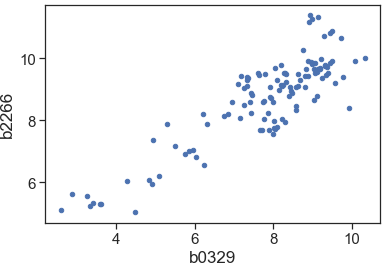

In [47]:
top2.plot(x='b0329', y='b2266', kind='scatter')

In [48]:
top2.corr()

locus_tag,b0329,b2266
locus_tag,,
b0329,1.000000,0.874675
b2266,0.874675,1.000000
